# MNIST - playing around

data source: http://yann.lecun.com/exdb/mnist/ 

In [31]:
# initialize libs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm.auto import trange
np.set_printoptions(suppress=True)

# torch libs
import torch
import torch.nn as nn 
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

# load data libs
import requests
import gzip
import os
import hashlib


In [32]:
def get_data(url):
    file_path = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open (file_path, 'rb') as f:
            data = f.read()
    else:
        with open(file_path, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

In [33]:
x_train = get_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [34]:
# making the sam layer from torch with numpy
layer_1 = np.zeros((784, 128), dtype=np.float32)
layer_2 = np.zeros((128, 10), dtype=np.float32)

# checking the types
(layer_1.dtype, layer_2.dtype)

(dtype('float32'), dtype('float32'))

### Methods

In [35]:
def forward(x):
    x = x.dot(layer_1)
    x = np.maximum(x, 0)
    x = x.dot(layer_2)
    return x

def forward_backwards(x, y):
    # define training 
    ret = np.zeros((len(y), 10), np.float32)
    ret[range(ret.shape[0]), y] = 1
    
    # --- forward
    x_layer_1 = x.dot(layer_1)
    relu = np.maximum(x_layer_1, 0)
    x_layer_2 = relu.dot(layer_2) # baked in x_relu = np.maximum(x_layer_1, 0)
    x_log_sum = x_layer_2 - log_sum_exp(x_layer_2).reshape((-1, 1))
    loss = (-ret * x_log_sum).mean(axis=1)
    
    # --- derivative: log_soft_max
    rret = -ret / len(y)
    d_log_sum = rret - np.exp(x_log_sum) * rret.sum(axis=1).reshape((-1,1)) # derivative layer 2
    d_relu =d_log_sum.dot(layer_2.T) 
    d_layer_2 = d_relu.T.dot(d_log_sum) # d_relu = d_log_sum.dot(layer_2.T)
    
    dd_layer_1 = (relu > 0).astype(np.float32) * (d_log_sum.dot(layer_2.T)) # derivative relu
    d_layer_1 = x.T.dot(dd_layer_1) # derivative layer 1

    return loss, x_layer_2, d_layer_1, d_layer_2

def log_sum_exp(x):
    return x.max(axis=1) + np.log(np.exp((x-x.max(axis=1).reshape((-1,1))).sum(axis=1)))

def initialize_layer(m, h):
    return (np.random.uniform(-1, 1, size=(m,h)) / np.sqrt(m * h)).astype(np.float32)

In [36]:
Y_test_predictions_out = forward(x_test.reshape((-1, 28*28)))
Y_test_predictions = np.argmax(Y_test_predictions_out, axis=1)
(y_test == Y_test_predictions).mean()

0.098

In [37]:
ret = (-Y_test_predictions_out[range(Y_test_predictions_out.shape[0]), y_test] 
       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))


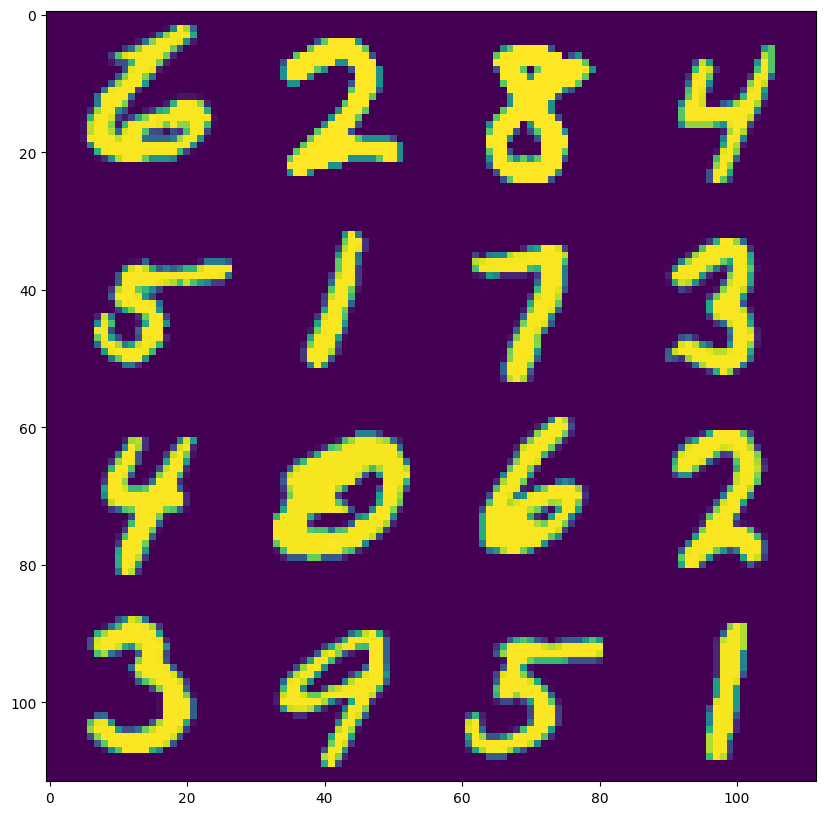

In [38]:
# grid
grid_var = 4
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:grid_var*grid_var]
temp = x_test[[x[1] for x in grid]]

figsize(10,10)
imshow(np.concatenate(temp.reshape((grid_var, 28*grid_var, 28)), axis=1))

In [39]:
sample = 1
-Y_test_predictions_out[sample, y_test[0]] + np.log(np.exp(Y_test_predictions_out[sample]).sum())

2.3025851

In [40]:
-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) + np.log(np.exp(Y_test_predictions_out).sum(axis=1))

array([2.3025851, 2.3025851, 2.3025851, ..., 2.3025851, 2.3025851,
       2.3025851], dtype=float32)

In [41]:
Y_test_predictions_out[:, y_test].shape

(10000, 10000)

In [42]:
Y_test_predictions_out[y_test.reshape((1,-1))].shape

(1, 10000, 10)

In [43]:
np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

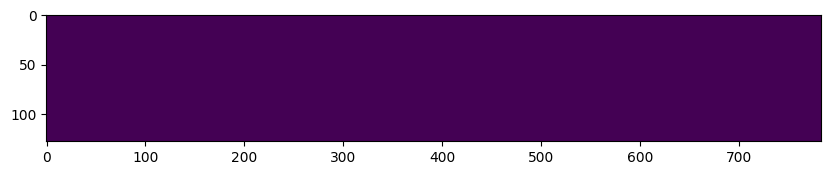

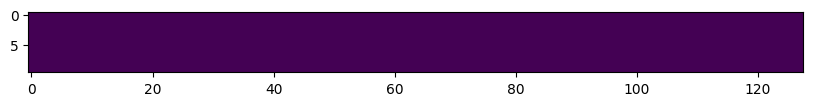

In [44]:
sample = [0,1,2,3]
loss, x_layer_2, d_layer_1, d_layer_2 = forward_backwards(x_test[sample].reshape((-1, 28*28)), y_test[sample])
imshow(d_layer_1.T)
figure()
imshow(d_layer_2.T)

In [47]:
# vaiables
learning_rate = 0.001
batch_size = 128
accuracies, losses = [], []
IMG_SIZE = 28*28

# init the new layers
np.random.seed(1000)
l1 = initialize_layer(IMG_SIZE, 128)
l2 = initialize_layer(128, 10)

for i in (t := trange(1000)):
    sample = np.random.randint(0, x_train.shape[0], size=batch_size)
    X = x_train[sample].reshape((-1, IMG_SIZE))
    Y = y_train[sample]
    t_loss, x_layer_2, d_layer1, d_layer2 = forward_backwards(X, Y)
    cc = np.argmax(layer_1, axis=1)
    accuracy = (cc == Y).mean()

    # SGD
    layer_1 = layer_1 - learning_rate * d_layer1
    layer_2 = layer_2 - learning_rate * d_layer2

    loss = t_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description(f'accuracy: {accuracy:.2f} loss: {loss:.2f}')

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13192/1995745068.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = (cc == Y).mean()
  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'bool' object has no attribute 'mean'